# Recurrent Neural Network Simulating a Dynamic System

In [77]:
! pip3 install sympy matplotlib

## 1. Definition of a Dynamic Process

Classes DynamicModel and DynamicProcess are defined file DynamicSystem.py. DynamicModel holds a description of a dynamic system in a symbolic form and as a differential equation. DynamicProcess helps to model a response (time series) of such model for a random input.   

In [2]:
from sympy.abc import s, t, y, x, y, z

In [3]:
from DynamicSystem import DynamicModel, DynamicProcess

### 1.1 Symbolic Definition of a Chosen System

In [4]:
G = 5*(s+1)/((s+3)*(s+2))
dynamic_model = DynamicModel(G)

In [5]:
dynamic_process = DynamicProcess(dynamic_model, 100)
dynamic_process.model

(5*s + 5)/((s + 2)*(s + 3))

### 1.2. Example of system responses for different inputs 

In [6]:
import matplotlib.pyplot as plt
import numpy as np

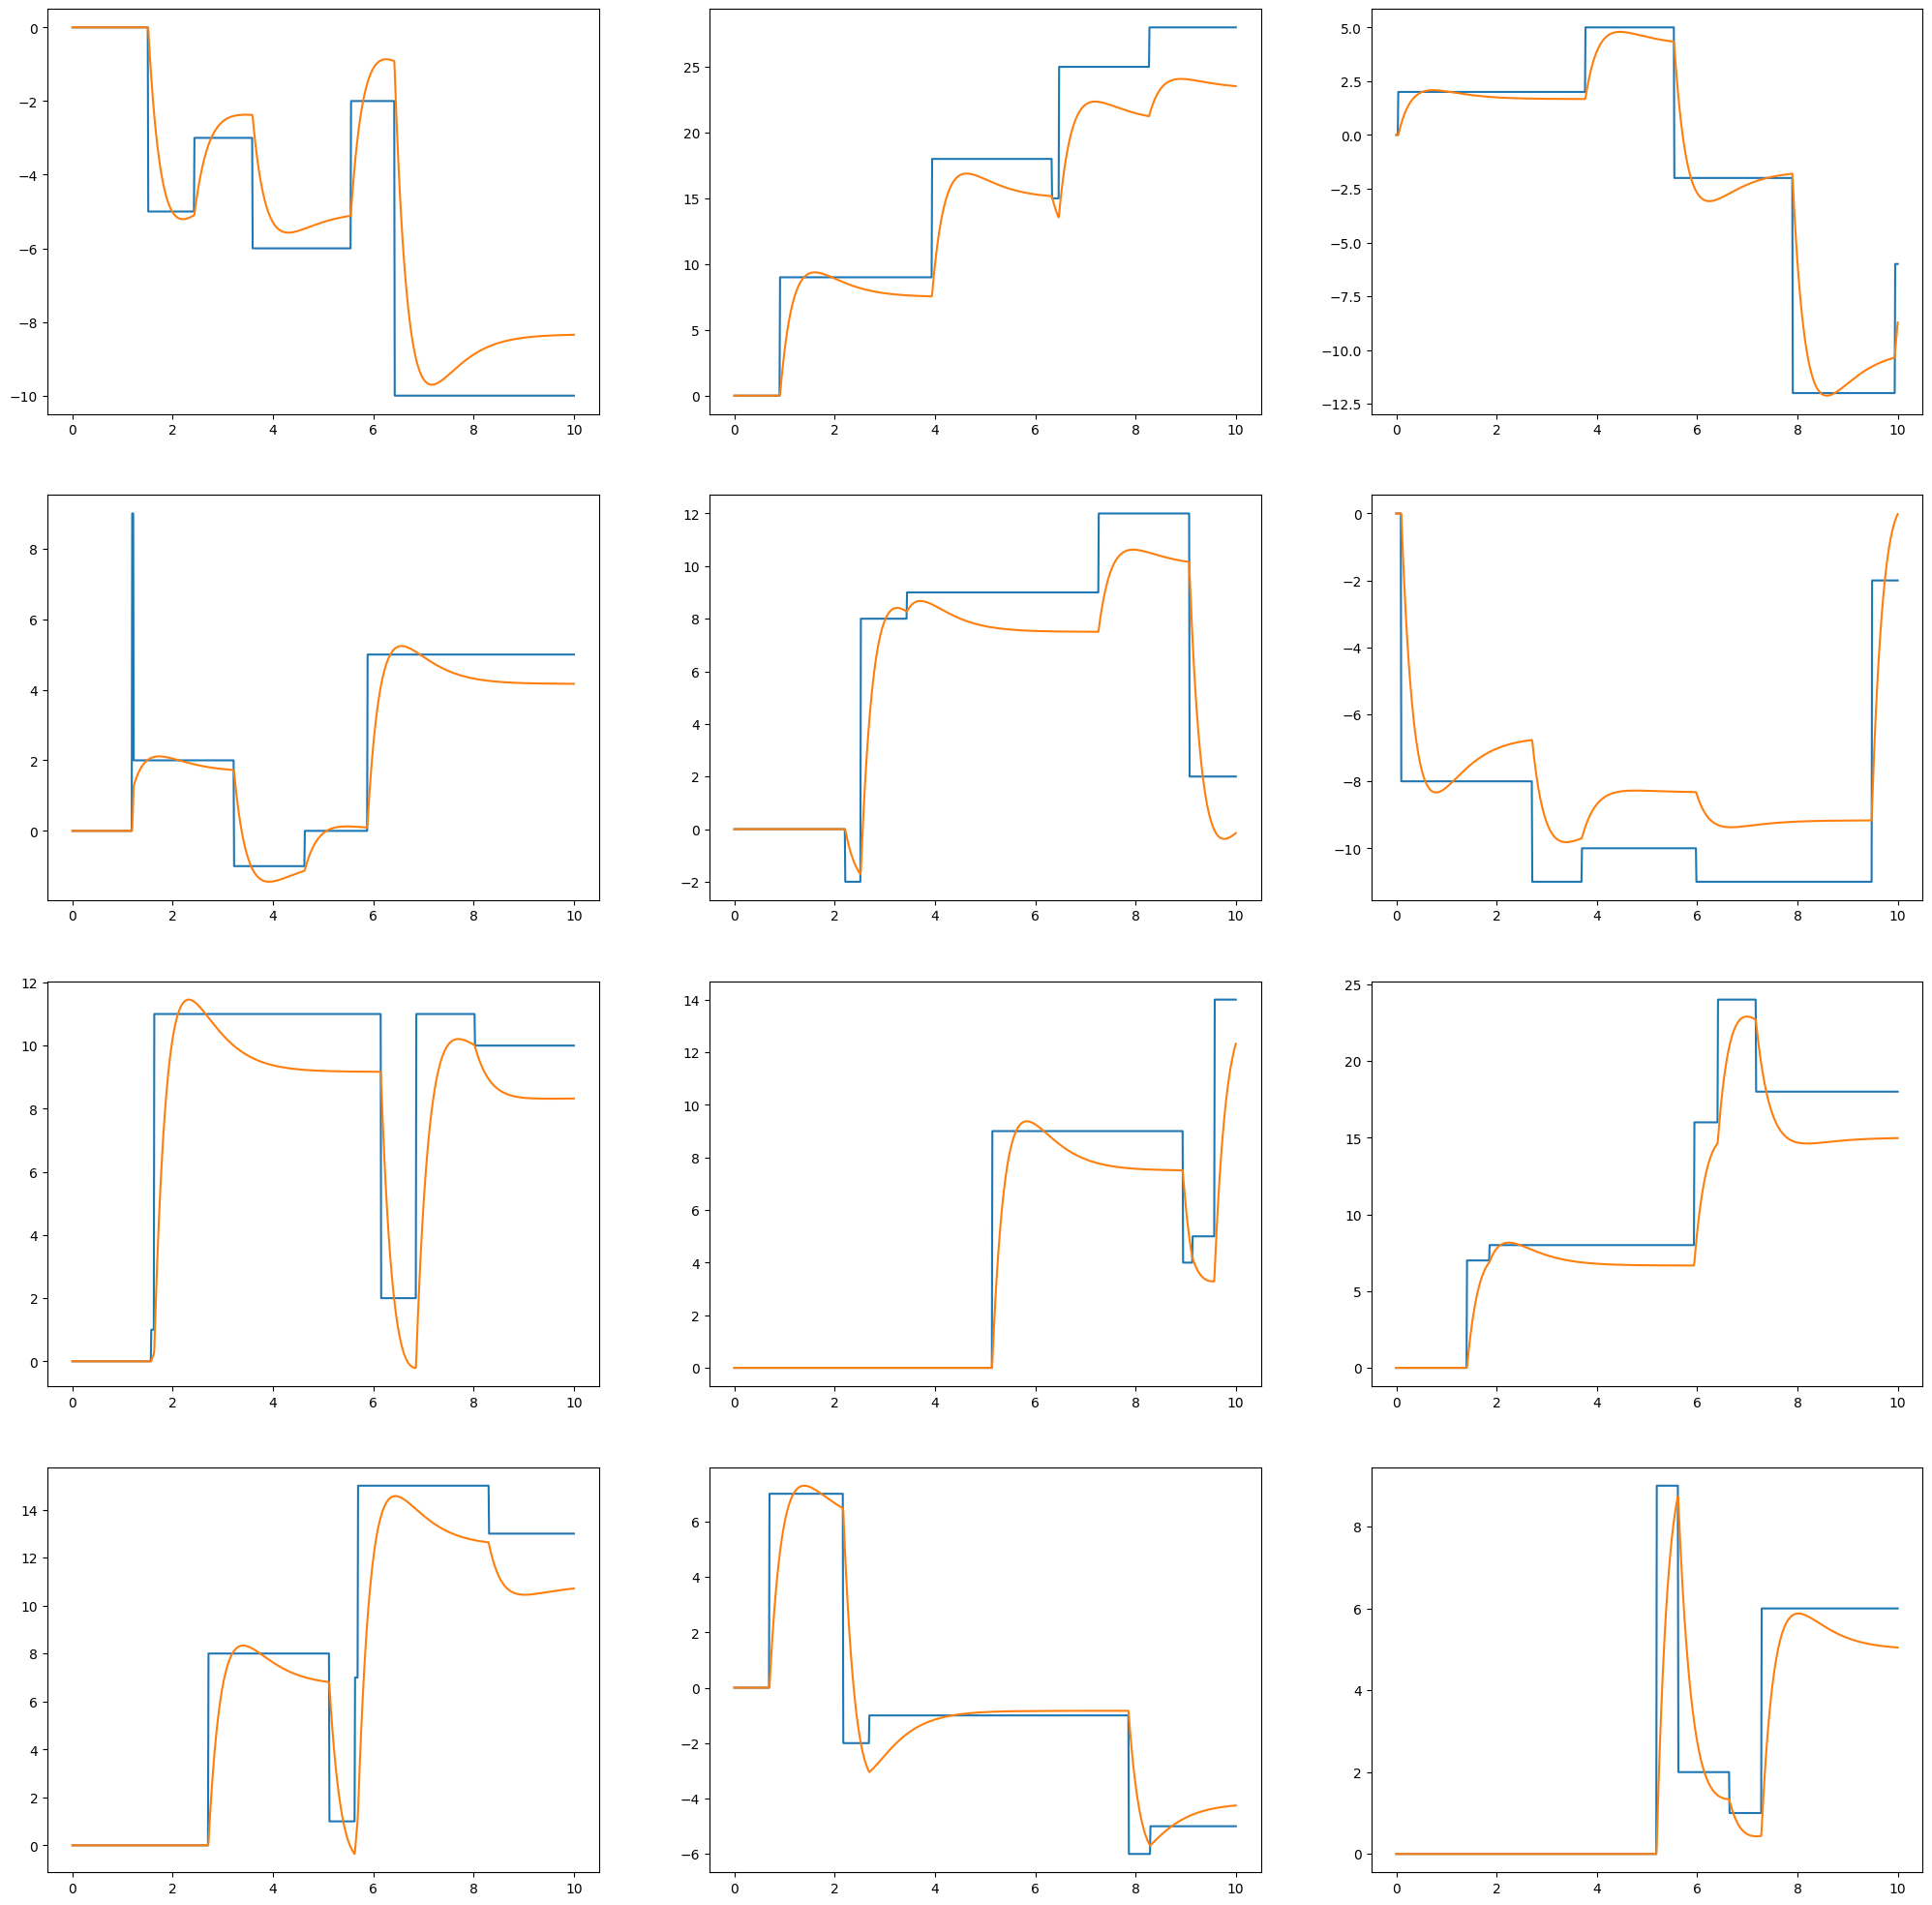

In [284]:
plt.figure(figsize=(25,25))
for i in range(12):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    plt.subplot(4,3,i+1)
    plt.plot(t, u)
    plt.plot(t, y)
plt.show()

## 2. Generate and Save Dataset

In [7]:
import pandas as pd
import os
import pymongo

In [ ]:
# Set up pymongo client
client = pymongo.MongoClient('localhost', 27017)
db = client.DynamicSystem
time_series_collection = db.time_series 

In [404]:
start = 40
stop = 60
for i in range(start, stop):
    t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    data = {'t':t, 'u':u, 'y':y}
    df = pd.DataFrame(data)
    
    # Save to csv
    df.to_csv(f'dataset/{i}.csv', index=False)
    
    # Save to pymongo
    # time_series_collection.insert_one(df.to_json())

### 2.1. Prepare Dataset

In [8]:
import tensorflow as tf
from tensorflow import keras

2022-11-02 11:21:49.757952: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-02 11:21:50.487171: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-02 11:21:50.487222: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-02 11:21:50.581368: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-02 11:21:52.067271: W tensorflow/stream_executor/platform/de

#### 2.1.1. Load files

In [9]:
dataset_path = 'dataset/'
dataset_files = [ f'{dataset_path}/{file}' for file in os.listdir(dataset_path) if 'csv' in file]

val_samples = round(len(dataset_files) * 0.2)
train_ds = dataset_files[:-val_samples]
val_ds = dataset_files[-val_samples:]

### 2.1. BatchBuilder

Class that creates batches of values for training and validation based on windows size. 

In [36]:
class TimeSeriesBatchBuilder(keras.utils.Sequence):
    """_summary_
    Helps to iterate over the dataset
    Args:
        keras (_type_): _description_
    """

    def __init__(self, dataset_files, window_size):
        self.dataset_files = dataset_files
        self.window_size = window_size
        self.file_len = len(pd.read_csv(self.dataset_files[0]))
        self.batch_size = self.file_len / self.window_size
        self.mean = 0 
        self.std = 0
    
    def __len__(self):
        return len(self.dataset_files)

    def __getitem__(self, idx):
        """Returns tuple (input, output) that corresponds to batch idx"""
        
        i = idx * self.batch_size
        batch_file = pd.read_csv(self.dataset_files[idx])
        
        x, y = [], []
        end = self.file_len - self.window_size
        for i in range(self.window_size, end):
            # x_temp = [batch_file['u'][i:i+self.window_size].values]
            # x_temp = np.concatenate((batch_file['u'][i:i+self.window_size].values, batch_file['y'][i:i+self.window_size].values))
            x_temp = np.array([batch_file['u'][i:i+self.window_size].values, batch_file['y'][i:i+self.window_size].values])
            x.append(x_temp)
            y.append(batch_file['y'][i+self.window_size])
        
        return np.array(x, dtype=np.float32), np.array(y, dtype=np.float32)

In [71]:
WINDOW_SIZE = 30
train_gen = TimeSeriesBatchBuilder(train_ds, window_size=WINDOW_SIZE)
val_gen = TimeSeriesBatchBuilder(val_ds, window_size=WINDOW_SIZE)

In [72]:
x, y = train_gen.__getitem__(2)

In [73]:
x.shape

(940, 2, 30)

In [40]:
y[0]

0.0

### Prepare Baseline model for benchmarking

In [174]:
class Baseline():

  def predict(self, inputs):
    return [[inputs[-1]]]

In [175]:
baseline_model = Baseline()

In [176]:
baseline_model.predict([1, 2, 3, 4])

[[4]]

## 3. Recurrent Neural Network

In [21]:
import tensorflow as tf
from keras.layers import Dropout
from keras.layers import Dense, LSTM, Input, Conv1D, SimpleRNN
from keras.optimizers import Adam
from keras.metrics import RootMeanSquaredError, MeanAbsoluteError
from keras.models import Sequential

### 3.1. Definitions of models

Models with different types of cells. 
- Standard Deep Neural Network (dnn)
- Convolutional Neural Network, which performs 1D filtering on each input vector (window)
- SimpleRNN - Recurrent Neural Netowrk - cell that keeps information about past values. 
- LSTM - long-short term memory cell, extension of RNN
- Custom model - a combination of different types of cells

In [74]:
def base_model(input_shape):
  pass


def dnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  
  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers):
    model.add(Dense(units=units))
    model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  
  return model


def cnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  CONV_WIDTH = 3
  
  model = Sequential()
  model.add(Input(shape=input_shape))
  for _ in range(layers):
    model.add(Conv1D(filters=units, activation='relu', kernel_size=(CONV_WIDTH)))
    model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
  
  return model


def lstm_model(input_shape, layers, units, dropout, loss, optimizer, metrics):

  model = Sequential()
  model.add(LSTM(units=units, batch_input_shape=input_shape, return_sequences=True, stateful=True))
  for _ in range(layers-1):
    model.add(LSTM(units=units, return_sequences=True, stateful=True))
    model.add(Dropout(rate=dropout))
    
  model.add(LSTM(units=units, return_sequences=False, stateful=True))
  model.add(Dropout(rate=dropout))
  model.add(Dense(units=1))
  
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
    
  return model 


def rnn_model(input_shape, layers, units, dropout, loss, optimizer, metrics):

  model = Sequential()
  model.add(SimpleRNN(units=units, input_shape=input_shape, return_sequences=True))
  for _ in range(layers-1):
    model.add(SimpleRNN(units=units, return_sequences=True))
    model.add(Dropout(rate=dropout))
    
  model.add(SimpleRNN(units=units, return_sequences=False))

  model.add(Dense(units=1))
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
    
  return model 


def custom_model(input_shape, layers, units, dropout, loss, optimizer, metrics):
  
  model = Sequential()
  model.add(LSTM(units=units, input_shape=input_shape, return_sequences=True))
  for _ in range(layers-1):
    model.add(Dense(units=units))
    model.add(Dropout(rate=dropout))

  model.add(Dense(units=1))
  model.compile(loss=loss,
                optimizer=optimizer,
                metrics=metrics)
  model.summary()
    
    
  return model 

In [93]:
learning_rate = 0.001

# Add patiance
input_shape = train_gen.__getitem__(2)[0].shape
print(input_shape)

params = {
    'input_shape': (2, WINDOW_SIZE),
    # 'input_shape': input_shape,
    'layers': 4,
    'units': 64,
    'dropout': 0.2,
	'loss': 'mean_squared_error',
	'optimizer': 'adam',
    'metrics': [RootMeanSquaredError(), MeanAbsoluteError()],
}

(940, 2, 30)


#### 3.1.1. List of defined and compiled models

In [94]:
models = {
    # 'dnn': dnn_model(**params),
    # 'cnn': cnn_model(**params),
    'rnn': rnn_model(**params),
    # 'lstm': lstm_model(**params),
    # 'custom': custom_model(**params)
}

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_7 (SimpleRNN)    (None, 2, 64)             6080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 2, 64)             8256      
                                                                 
 dropout_50 (Dropout)        (None, 2, 64)             0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 2, 64)             8256      
                                                                 
 dropout_51 (Dropout)        (None, 2, 64)             0         
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 2, 64)             8256      
                                                                 
 dropout_52 (Dropout)        (None, 2, 64)           

# 4. Training

## 4.1. Loss visualization

In [86]:
def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    # plt.show()

## 4.2. Training each model

Training each type of model

In [92]:
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint

In [95]:
EPOCHS = 2000

In [96]:
# to_train = ['dnn', 'cnn', 'lstm', 'rnn', 'custom']
to_train = ['rnn']

In [97]:
filepath= 'best_current_models/{0}/weights.hdf5'

In [69]:
histories = {}
for i, name in enumerate(to_train):
    print(f'Training {name.upper()}')
    for _ in range(EPOCHS):
        
        checkpoint = ModelCheckpoint(filepath.format(name), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
        histories[name] = models[name].fit(train_gen, epochs=1, batch_size=input_shape[0], validation_data=val_gen, shuffle=False)
        models[name].reset_states()
    # clear_output()

Training LSTM
48/48 [==============================] - 22s 452ms/step - loss: 1.0698 - root_mean_squared_error: 1.0343 - mean_absolute_error: 0.7275 - val_loss: 0.8904 - val_root_mean_squared_error: 0.9436 - val_mean_absolute_error: 0.6621


In [98]:
histories = {}
for i, name in enumerate(to_train):
    print(f'Training {name.upper()}')
    checkpoint = ModelCheckpoint(filepath.format(name), monitor='val_loss', verbose=0, save_best_only=True, save_weights_only=False, mode='auto')
    histories[name] = models[name].fit(train_gen, epochs=EPOCHS, validation_data=val_gen, shuffle=False, callbacks=[checkpoint])
    # clear_output()

Training RNN
Epoch 1/2000
48/48 [==============================] - 13s 165ms/step - loss: 22.3808 - root_mean_squared_error: 4.7308 - mean_absolute_error: 3.0354 - val_loss: 7.1540 - val_root_mean_squared_error: 2.6747 - val_mean_absolute_error: 1.9568
Epoch 2/2000
48/48 [==============================] - 9s 185ms/step - loss: 8.8127 - root_mean_squared_error: 2.9686 - mean_absolute_error: 1.7219 - val_loss: 4.2399 - val_root_mean_squared_error: 2.0591 - val_mean_absolute_error: 1.5324
Epoch 3/2000
48/48 [==============================] - 8s 162ms/step - loss: 6.0560 - root_mean_squared_error: 2.4609 - mean_absolute_error: 1.3682 - val_loss: 2.5095 - val_root_mean_squared_error: 1.5842 - val_mean_absolute_error: 1.0772
Epoch 4/2000
48/48 [==============================] - 7s 152ms/step - loss: 4.6251 - root_mean_squared_error: 2.1506 - mean_absolute_error: 1.1700 - val_loss: 1.4840 - val_root_mean_squared_error: 1.2182 - val_mean_absolute_error: 0.7414
Epoch 5/2000
48/48 [=============

KeyboardInterrupt: 

In [ ]:
models['rnn'].load_weights("\\codes\\recursive\\saved_models\\weights.hdf5")

Training history of each model

In [100]:
i=1
plt.figure(figsize=(25,25))
for name, history in histories.items():
    plt.subplot(3,2,i)
    visualize_loss(history, f'Training and Validation Loss - {name.upper()}')
    i+=1
plt.show()

<Figure size 2500x2500 with 0 Axes>

# 5. Testing

## 5.1. Generating test time series

From validation dataset

In [21]:
df = pd.read_csv(val_ds[0])
t, u, y = df['t'].values, df['u'].values, df['y'].values

Generate new simulation

In [226]:
t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)

In [46]:
def create_full_prediction(t, u, y, model, window_size=15):
    y_pred = []
    u_extended = np.concatenate((np.zeros(window_size), u))
    y_window = np.zeros(window_size)
    for i in range(len(t)):
        
        input_for_pred = np.array([[u_extended[i:i+window_size], y_window]])
        y_hat = model.predict(input_for_pred)[0][0]
        y_pred.append(y_hat)
        
        y_window = np.roll(y_window, -1)
        y_window[window_size-1] = y_hat
        
    return y_pred

## 5.2. Prediction of specific model

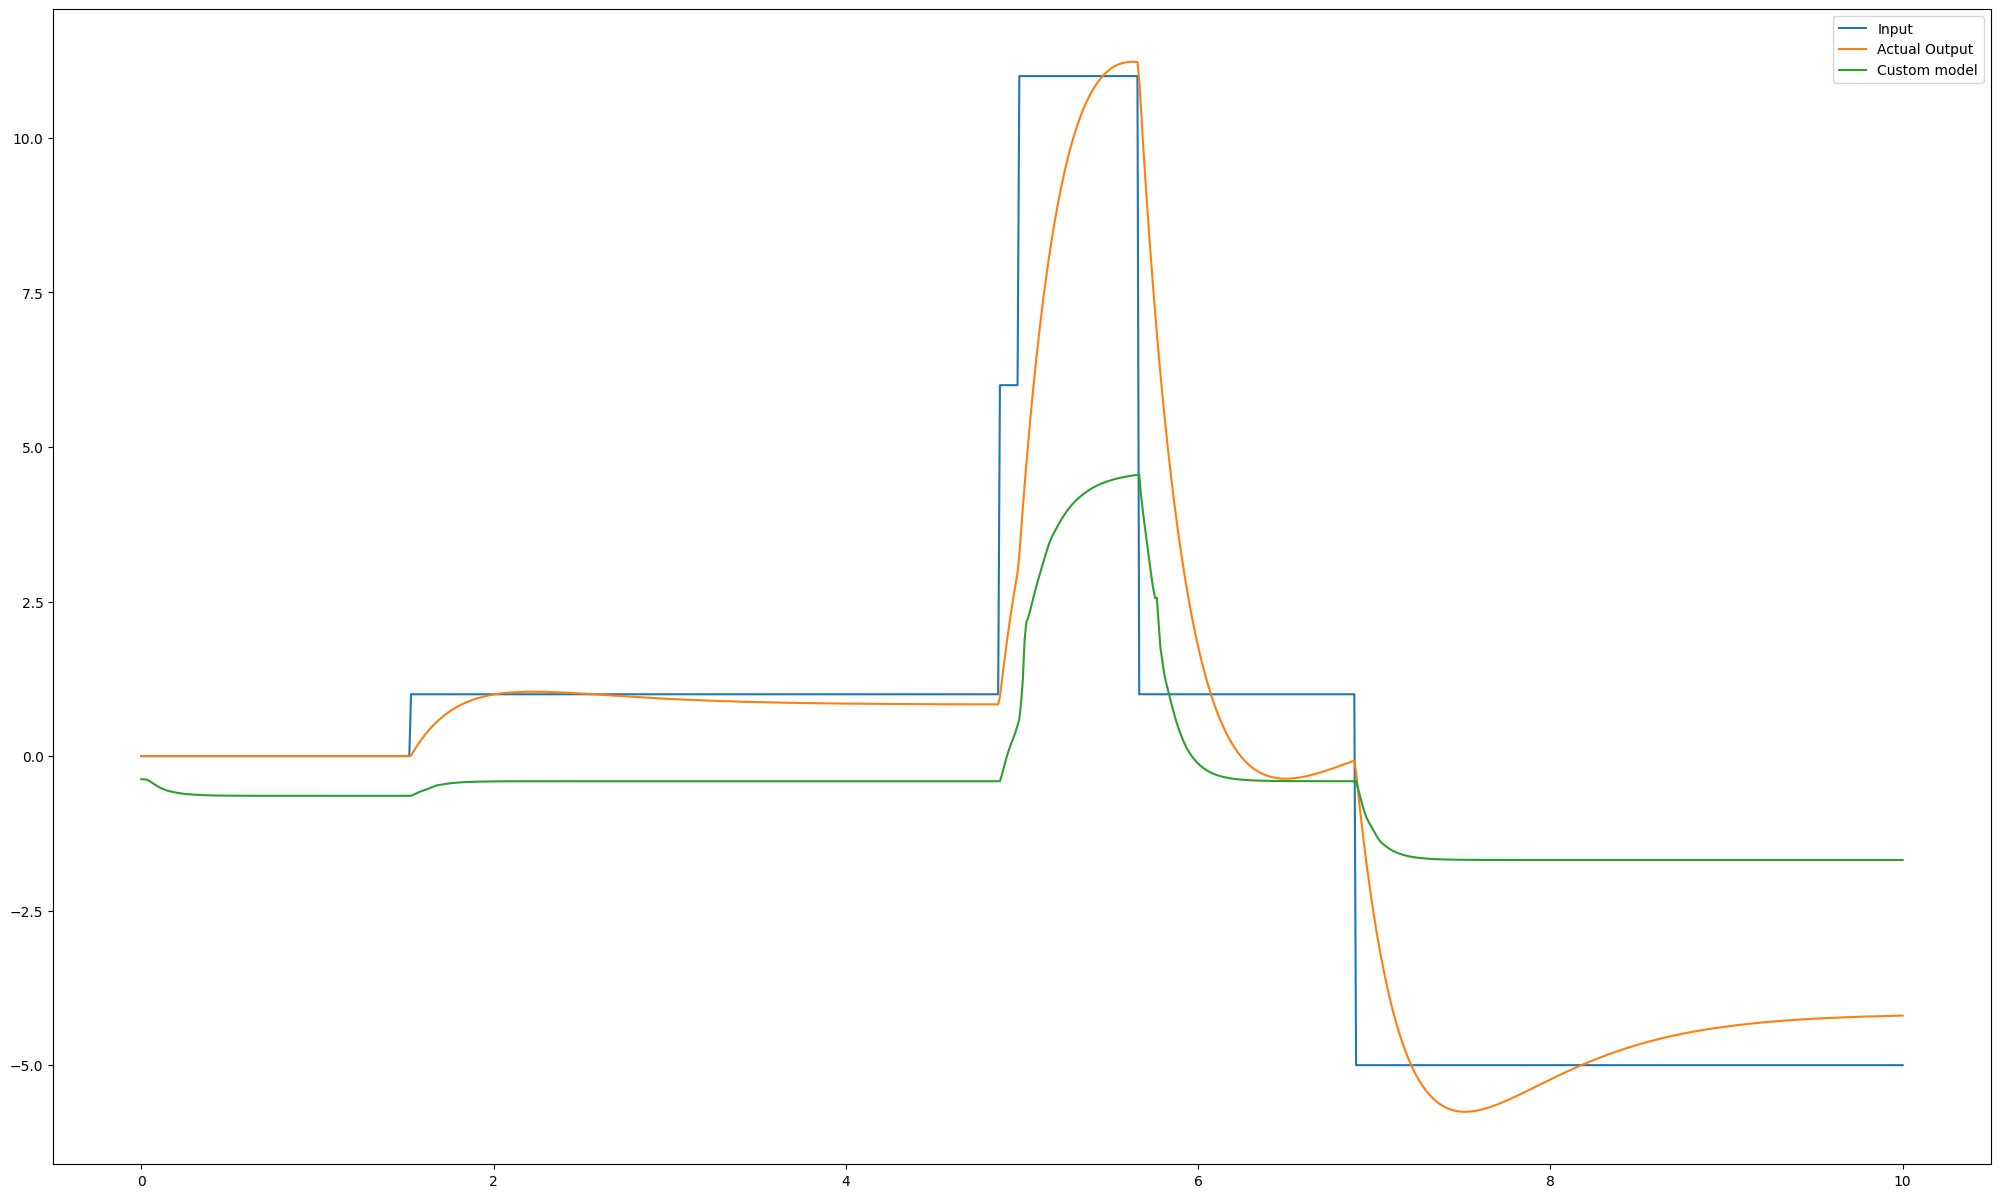

In [236]:
plt.figure(figsize=(25,15))
plt.plot(t, u)
plt.plot(t, y)
plt.plot(t, prediction)
plt.legend(['Input', 'Actual Output','Custom model'])
plt.show()

## 5.3. Predict and compare all models

In [230]:
predictions = {}
for name, model in models.items():
    predictions[name] = create_full_prediction(t, u, y, model, window_size=WINDOW_SIZE)

1/1 [==============================] - 0s 51ms/step


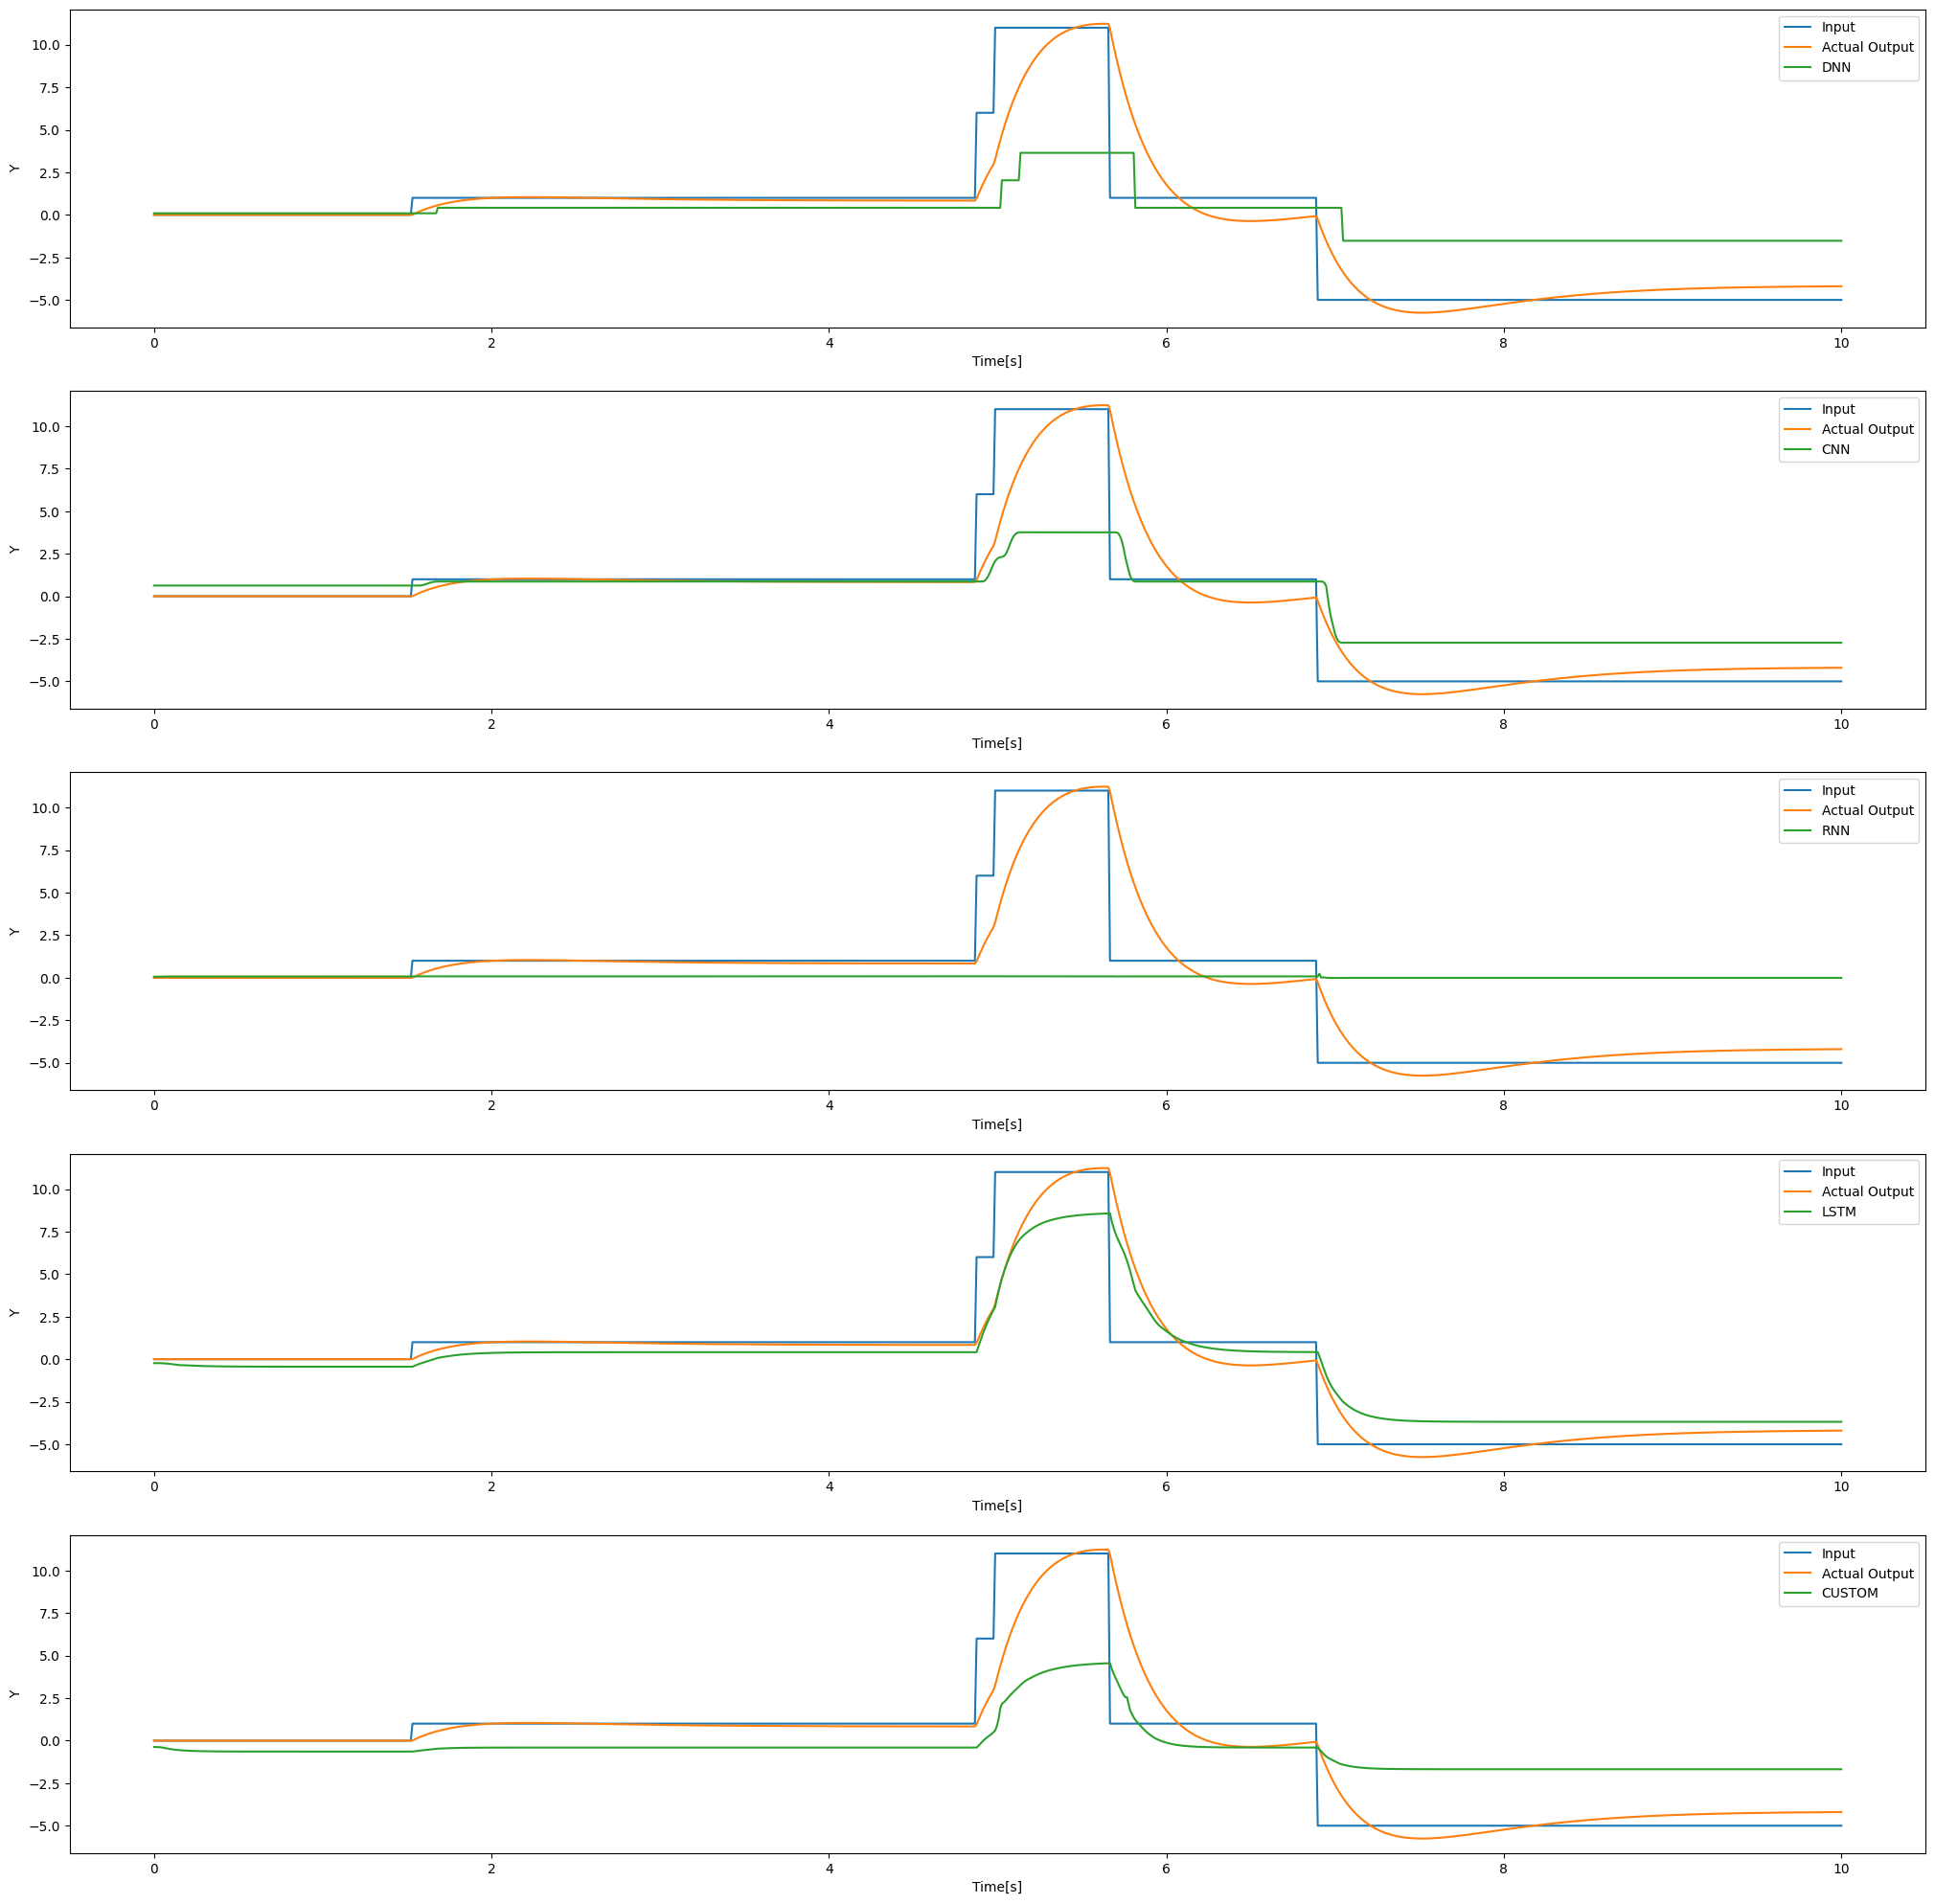

In [232]:
i=1
plt.figure(figsize=(25,25))
for name, prediction in predictions.items():
    plt.subplot(5,1,i)
    plt.plot(t, u)
    plt.plot(t, y)
    plt.plot(t, prediction)
    plt.xlabel('Time[s]')
    plt.ylabel('Y')
    plt.legend(['Input', 'Actual Output', name.upper()])
    i+=1
plt.show()

So far, the best performing model was the one created with only LSTM. 

Let's check how LSTM model performs in more simulations.

In [70]:
simulations = []
predictions = []
for i in range(4):
    # Generate new simulations
    # t, u, y = dynamic_process.generate_time_series(10, 1000, new_inputs=True)
    
    # Read simulations from validation dataset
    df = pd.read_csv(val_ds[i])
    t, u, y = df['t'].values, df['u'].values, df['y'].values
    
    simulations.append([t, u, y])
    predictions.append(create_full_prediction(t, u, y, models['lstm'], window_size=WINDOW_SIZE))
    models['lstm'].reset_states()

InvalidArgumentError: Graph execution error:

Specified a list with shape [940,30] from a tensor with shape [1,30]
	 [[{{node TensorArrayUnstack/TensorListFromTensor}}]]
	 [[sequential_9/lstm_33/PartitionedCall]] [Op:__inference_predict_function_980185]

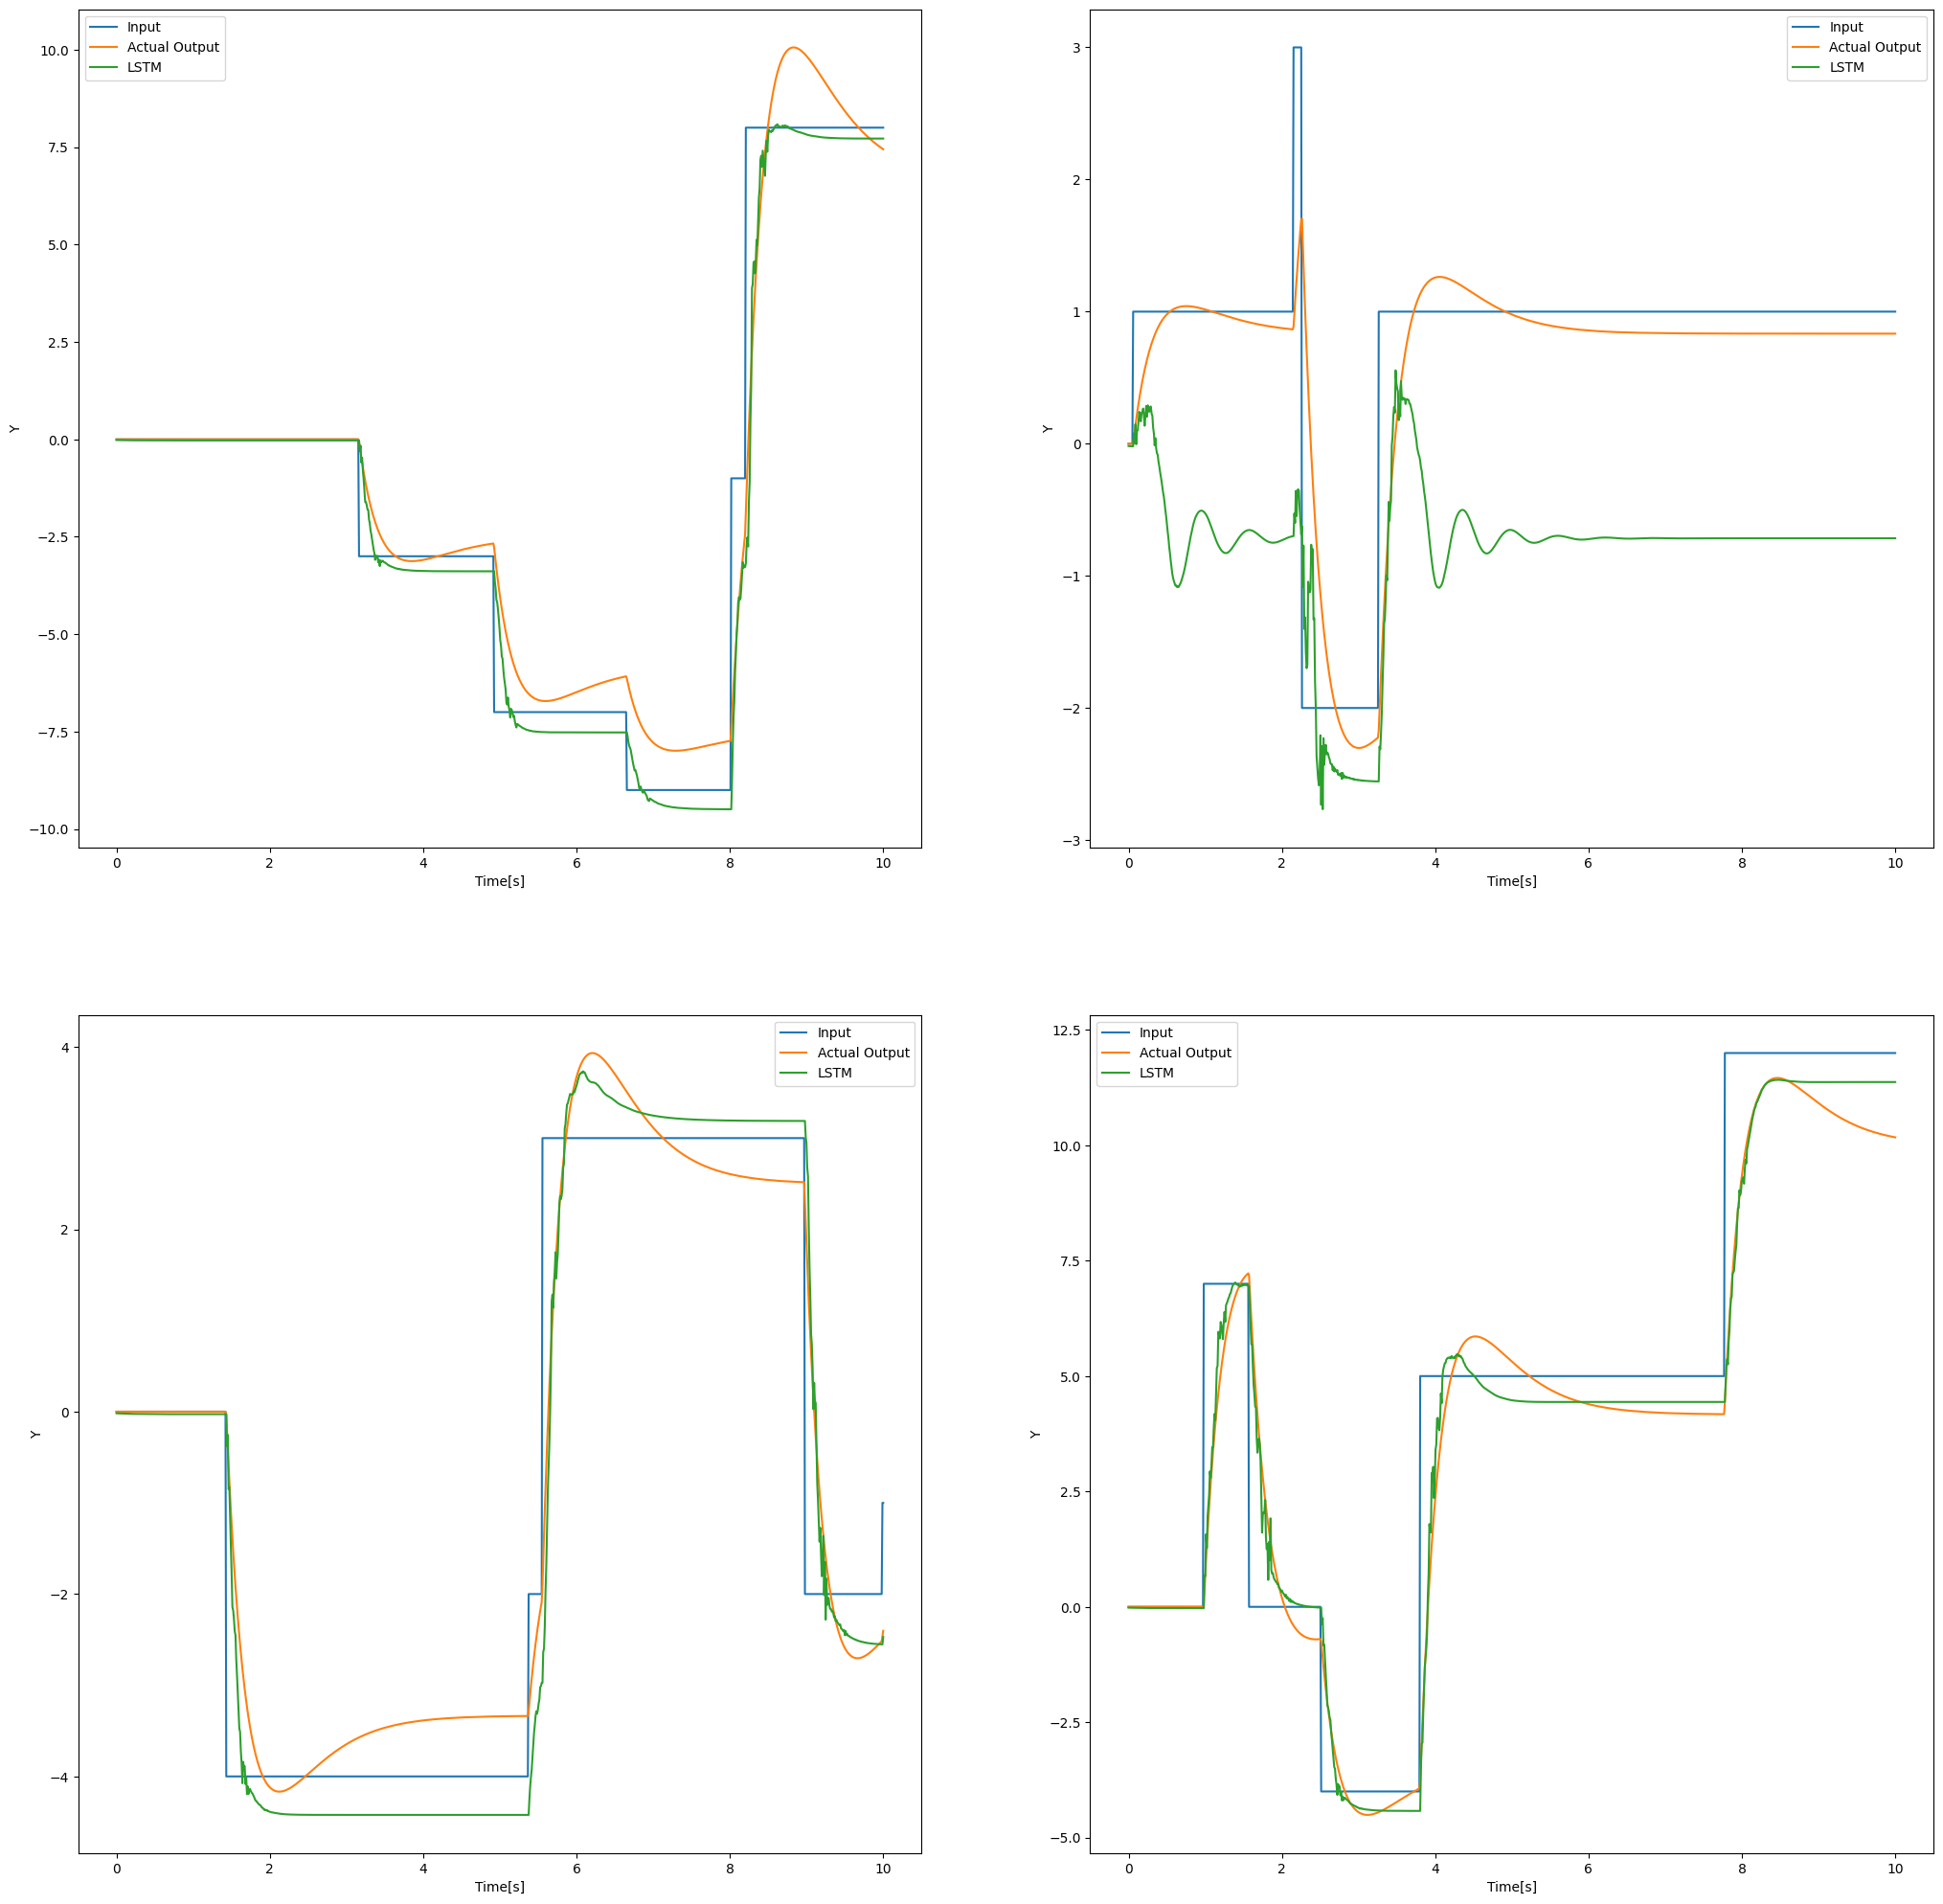

In [56]:
plt.figure(figsize=(25,25))
for i in range(4):
    t, u, y = simulations[i]
    prediction = predictions[i]
    plt.subplot(2,2,i+1)
    plt.plot(t, u)
    plt.plot(t, y)
    plt.plot(t, prediction)
    plt.xlabel('Time[s]')
    plt.ylabel('Y')
    plt.legend(['Input', 'Actual Output', 'LSTM'])
    i+=1
plt.show()

# 6. Save models

In [ ]:
name = 'rnn'

In [245]:
models[name].save(f'models/{name}')

INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


In [234]:
for name, model in models.items():
    model.save(f'models/{name}')

INFO:tensorflow:Assets written to: models/dnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/cnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/rnn/assets


INFO:tensorflow:Assets written to: models/lstm/assets


INFO:tensorflow:Assets written to: models/lstm/assets


INFO:tensorflow:Assets written to: models/custom/assets


INFO:tensorflow:Assets written to: models/custom/assets


# 7. Load models